In [64]:
import h5py
import pandas as pd
from pathlib import Path
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal
import os
import glob 
from scipy.ndimage import uniform_filter1d

In [61]:
''' GOAL PART1: having a big unique csv file with data from all the videos 

to do that we need to: 
OK- read the hdf5 files
OK- store information in the right coloumn and add missing coloums for each h5 file 
coloumns we want are: 
        fly id (exp,arena,maze) -> get it from the directory with command inputpath.parent.name
        frame (called index) -> already there, to be extracted
        X and Y coordinates of head, abdomen, thorax -> already there, to be extracted
        time (in seconds) -> compute it (29 frames per sec)
        starving status  -> depends on experiment 
        habituation status -> depends on arena number
    area (blu_obj, oran_obj, neutral) -> need to define thresholds either with gimpy or with the pixel thing (see notes on word) 

- join all files together 
- save csv file 

'''

' GOAL PART1: having a big unique csv file with data from all the videos \n\nto do that we need to: \nOK- read the hdf5 files\nOK- store information in the right coloumn and add missing coloums for each h5 file \ncoloumns we want are: \n        fly id (exp,arena,maze) -> get it from the directory with command inputpath.parent.name\n        frame (called index) -> already there, to be extracted\n        X and Y coordinates of head, abdomen, thorax -> already there, to be extracted\n        time (in seconds) -> compute it (29 frames per sec)\n        starving status  -> depends on experiment \n        habituation status -> depends on arena number\n    area (blu_obj, oran_obj, neutral) -> need to define thresholds either with gimpy or with the pixel thing (see notes on word) \n\n- join all files together \n- save csv file \n\n'

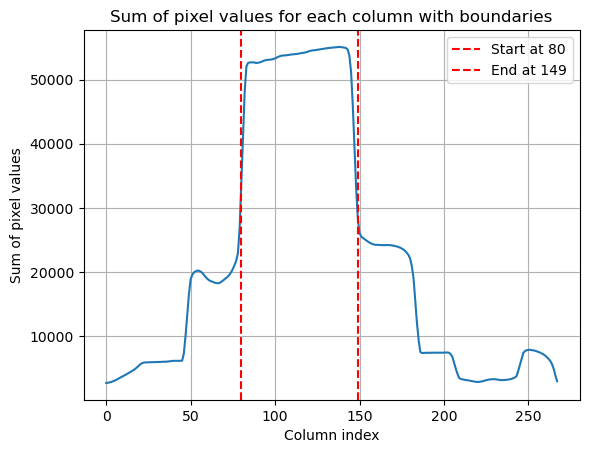

Plateau starts at column index: 80
Plateau ends at column index: 149


In [65]:
# List all h5 files in the directory and subdirectories
input = Path("c:/Users/win/Desktop/Alice_Samara_Videos2") #CHANGE PATH HERE
h5_files = list(input.rglob("*.h5"))

dataframes = []  # List to hold all dataframes

#cycle to run the code for each video related h5 file in all the paths where it found some 

for testpath in h5_files:
    #get node names and locs matrix with all info
    with h5py.File(testpath.as_posix(), "r") as f:
                dset_names = list(f.keys())
                locs = f["tracks"][:].T #this has the coordinates of the nodes (x,y)
                node_names = [n.decode() for n in f["node_names"][:]]
            #LEGEND: locs[0] refers to the first frame
            #locs [0][0] first frame, abdomen (1 = thorax, 2 = head)
            #locs [0][0][0] first frame, abdomen, x value (1 = y value)
            #locs 
    #get all locations for all the frames of a video divided by body part 
    HEAD_INDEX = 2
    THORAX_INDEX = 1
    ABDO_INDEX = 0
    head_loc = locs[:, HEAD_INDEX, :, :]
    thorax_loc = locs[:, THORAX_INDEX, :, :]
    abdo_loc = locs[:, ABDO_INDEX, :, :]
    
    #build a dataframe with locations of different body parts divided by x and y (flatten to remove a parenthesis and save them in df)
    df = pd.DataFrame(
        {
            "head_x": head_loc[:, 0].flatten(),
            "head_y": head_loc[:, 1].flatten(),
            "thorax_x": thorax_loc[:, 0].flatten(),
            "thorax_y": thorax_loc[:, 1].flatten(),
            "abdo_x": abdo_loc[:, 0].flatten(),
            "abdo_y": abdo_loc[:, 1].flatten(),
        }
    ).reset_index()
    #df.head() to print and see how it looks like

    #now we add the missing columns to the dataframe

    #time (in seconds) of each frame considering that we have 29 frames for second
    seconds_per_frame = 1/29
    df["time"] = df["index"]*seconds_per_frame    

    #fly ids (exp,arena,maze)
    #take the fly id from the directory name
    #find the experiment/arena/maze number in the path knowing that it is always next to the word experiment/arena/maze
    path = testpath.parent.parent.name
    df["arena"] = re.search(r'arena(\d+)', path).group(1)
    path = testpath.parent.name
    df["maze"] = re.search(r'maze(\d+)', path).group(1)
    path = testpath.parent.parent.parent.name
    df["exp"] = re.search(r'experiment(\d+)', path).group(1)

    #starving status (starved in experiment2, experiment5 fed in experiment1, experiment3, experiment4 )
    fed_conditions = ("mazes_experiment2_Videos", "mazes_experiment3_Videos")
    df["starving_cond"] = df["exp"].apply(lambda x: "starved" if any(cond in x for cond in fed_conditions) else "fed")

    #habituation status (unused if arena0, arena1, arena2, blue if arena3, arena4, arena5, orange if arena6, arena7, arena8)
    blue_arenas = ("arena3", "arena4", "arena5")
    orange_arenas = ("arena6", "arena7", "arena8")
    df["habituation_cond"] = df["arena"].apply(lambda x: "blue" if any(cond in x for cond in blue_arenas) else "orange" if any(cond in x for cond in orange_arenas) else "unused")

    #area (blu_obj, oran_obj, neutral) -> need to define thresholds 
    # we calculate the sum of pixels in each coloumn of each frame

    #first we get the video present in the folder of the experiment, arena, maze we are analyzing
    directory = os.path.dirname(testpath)
    trying = glob.glob(os.path.join(directory, '*.mp4'))

    #Get the first frame of the video
    cap = cv2.VideoCapture(trying[0])
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = cap.read()
    cap.release()

    # Convert the image to grayscale if it's not already
    if len(frame.shape) == 3:  # Check if the image has color channels
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the sum of pixel values for each column (x-coordinate)
    column_pixel_sums = np.sum(frame, axis=0)

    # Create an array of x-coordinates
    x_values = np.arange(len(column_pixel_sums))

    '''# Create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the pixel sums
    ax.plot(x_values, column_pixel_sums)

    # Add a grid
    ax.grid(True)

    # Set the x-ticks with an interval of 5
    ax.set_xticks(np.arange(min(x_values), max(x_values)+1, 5))

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    # Set the labels and title
    ax.set_xlabel('Column index')
    ax.set_ylabel('Sum of pixel values')
    ax.set_title('Sum of pixel values for each column')'''

    # Find x coordinates of the plateau 
    column_pixel_sums_1d = column_pixel_sums.flatten()

    # Apply a smoothing function to reduce noise
    smoothed_sums = uniform_filter1d(column_pixel_sums_1d, size=4)

    # Threshold for detecting the plateau (on the y = 3000, distance along x of the plateau = at least 40 )
    threshold = 30000
    min_plateau_length = 40

    # Find indices where the smoothed sums exceed the threshold
    above_threshold = smoothed_sums > threshold

    # Identify the start and end points of the plateau
    plateau_start = None
    plateau_end = None

    for i in range(1, len(above_threshold)):
        if above_threshold[i] and not above_threshold[i-1]:
            start = i
        if not above_threshold[i] and above_threshold[i-1]:
            end = i
            if end - start >= min_plateau_length:
                plateau_start = start
                plateau_end = end
                break

    # Mark the boundary points on the plot
    plt.plot(smoothed_sums)
    if plateau_start is not None and plateau_end is not None:
        plt.axvline(x=plateau_start, color='r', linestyle='--', label=f'Start at {plateau_start}')
        plt.axvline(x=plateau_end, color='r', linestyle='--', label=f'End at {plateau_end}')
    plt.xlabel('Column index')
    plt.ylabel('Sum of pixel values')
    plt.title('Sum of pixel values for each column with boundaries')
    plt.legend()
    plt.grid(True)
    plt.show()

    left_peak = plateau_start
    right_peak = plateau_end

#OLD METHOD 
    ''' peaks, properties = scipy.signal.find_peaks(column_pixel_sums_1d, height = (30_000, 70_000), distance=55)

    #it returns the indices of peaks in column_pixel_sums_1d that satisfy all given conditions
    #properties is a dictionary containing properties of the peaks and we are interested in the height of them

    # Get the heights of the peaks
    peak_heights = properties['peak_heights']

    # Sort the peaks by their heights in descending order and get the indices of the two highest peaks
    highest_peaks_indices = np.argsort(peak_heights)[-2:]

    # Get the x values of the two highest peaks
    highest_peaks_x_values = peaks[highest_peaks_indices]

    #plot red dots on the 2 highest peaks on the graph
    ax.plot(highest_peaks_x_values, column_pixel_sums[highest_peaks_x_values], 'ro')
    # Show the plot
    plt.show()

    #extract the first and second highest peak values
    left_peak = highest_peaks_x_values[0]
    right_peak = highest_peaks_x_values[1]'''



    #let's add a column with the position of the blue object relative to the fly prospective
    df["pos_blue_obj"] = "left"
    # Add "area" column to DataFrame

    #if we are analysign the maze 1 right and left are opposite (because it was rotated during the cropping)
    if df["maze"].iloc[0] == "1":
        left_peak, right_peak = right_peak, left_peak
        df["pos_blue_obj"] = "right"
        
    # if the thorax of the fly is lower than the left peak, the fly is in the left area (corresponding to the blue object)
    #if it is higher than the right peak, the fly is in the right area (right obj), otherwise it is in the neutral area
    #the y coordinate of the thorax also have to be over the middle line to be sure the fly is not in the resting area (which is larger). Max y value is around 480 so we consider 240 as the middle line

    df["area"] = "neutral"
    
    #if thorax_x is lower than left peak and thorax_y < 240, the fly is in the left area (y axes goes from top to bottom so lower values are higher on the screen)
    df.loc[(df["thorax_x"] < left_peak) & (df["thorax_y"] < 240), "area"] = "blue"
    df.loc[(df["thorax_x"] > right_peak) & (df["thorax_y"] < 240), "area"] = "orange"

    #save the dataframe in the list of dataframes
    dataframes.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dataframes)

# Save the concatenated dataframe to a CSV file and specify the path
#if the file already exhists remove it
if os.path.exists(input / 'fly_data_AliceSamara.csv'):
    os.remove(input / 'fly_data_AliceSamara.csv')
combined_df.to_csv(input / 'fly_data_AliceSamara.csv', index=False)

#to see the single dataframe
#df 
#to see the concatenated dataframe
#combined_df